In [1]:
import scanpy as sc
import scanpy.external as sce
import muon as mu
import numpy as np
import loompy as lp
import pandas as pd
import anndata as ad
import seaborn as sns
import os
import re
import json
import decoupler as dc
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats
import gseapy

In [2]:
TNC_ad = sc.read_h5ad('HSCT_anndata.h5ad')
NK_ad = sc.read_h5ad('NK_anndata.h5ad')

#### Figure 7A

In [4]:
TNC_ad.obs["celltype"] = TNC_ad.obs["leiden_res_0.4"].map(
    {
        "0": "Monocyte",
        "1": "Neutrophil",
        "2": "Neutrophil",
        "3": "B Cell",
        "4": "Myelocyte",
        "5": "Myelocyte",
        "6": "Promyelocyte",
        "7": "Megakaryocyte",
        "8": "T Cell",
        "9": "NK Cell",
        "10": "Myeloid DC",
        "11": "Erythrocyte"
    }
)
#Save the anndata with the new 'celltype' obs column
#TNC_ad.write_h5ad('HSCT_anndata.h5ad', compression='lzf')

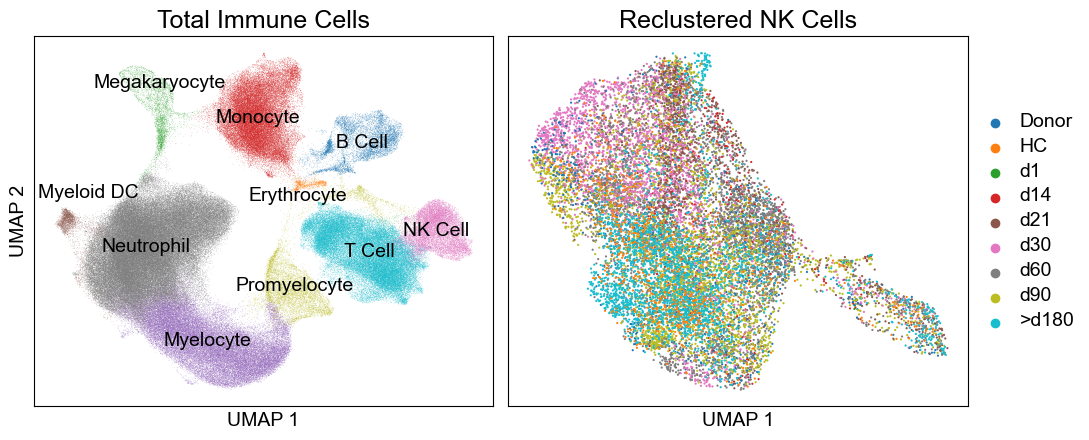

In [17]:
import matplotlib.pyplot as plt
import scanpy as sc

# 1. Initialize the figure with 2 subplots (side-by-side)
# figsize=(width, height). (12, 6) is usually good for a 2-panel plot.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4.5))

# ==========================================
# LEFT PANEL: Total Immune Cells (ax1)
# ==========================================

sc.pl.umap(TNC_ad, 
           color='celltype', 
           legend_loc='on data', 
           show=False, 
           ax=ax1,              # <--- Plot on the left axis
           title='')            # We set title manually below

# Customizing ax1
ax1.set_title('Total Immune Cells', fontname='Arial', fontsize=18)
ax1.set_xlabel('UMAP 1', fontname='Arial', fontsize=14)
ax1.set_ylabel('UMAP 2', fontname='Arial', fontsize=14)

# Customize the 'on data' labels
for t in ax1.texts:
    t.set_fontname('Arial')
    t.set_fontsize(14)
    t.set_fontweight('bold')
    
    # Specific Label Shifting
    if t.get_text() == 'Megakaryocyte':
        x, y = t.get_position()
        t.set_position((x, y + 2))

    elif t.get_text() == 'Myeloid DC':
        x, y = t.get_position()
        t.set_position((x + 1.1, y + 2.2))

    elif t.get_text() == 'Erythrocyte':
        x, y = t.get_position()
        t.set_position((x - 0.5, y - 0.8))

# ==========================================
# RIGHT PANEL: Reclustered NK Cells (ax2)
# ==========================================

sc.pl.umap(NK_ad, 
           color='Time', 
           size=10, 
           show=False, 
           ax=ax2,              # <--- Plot on the right axis
           title='',
           palette='tab10')

# Customizing ax2
ax2.set_title('Reclustered NK Cells', fontname='Arial', fontsize=18)
ax2.set_xlabel('UMAP 1', fontname='Arial', fontsize=14)
ax2.set_ylabel('') # No Y-label as requested

# Customize the side legend
# Note: When passing an axis to scanpy, sometimes the legend handling 
# requires getting the legend object explicitly if it's outside the plot.
legend = ax2.legend_
if legend:
    for t in legend.get_texts():
        t.set_fontsize(14)
        t.set_fontname('Arial')

# ==========================================
# FINAL LAYOUT & SAVE
# ==========================================

plt.tight_layout() # Prevents overlaps between the two plots
plt.savefig('figures/Combined_Figure_7A.png', dpi=300, bbox_inches='tight')
plt.show()

#### Figure 7B-E

In [18]:
# Generate the 7-color blue gradient (from light to dark)
# We skip the first 2 colors of the 9-step palette to avoid colors that are too light
color_gradient = list(sns.color_palette("RdPu", 9).as_hex()[2:])

# Create the final color list in the correct order
final_color_list = [
    '#98019F',  # Donor
    '#FEE5E7', # HC
] + color_gradient # The 7 time points

# --- 2. Store the colors in the AnnData object ---
# The key MUST be '[groupby_key]_colors'
NK_ad.uns['Time_colors'] = final_color_list

This data comes from the following genesets in MsigDB:

https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/GSE7764_IL15_NK_CELL_24H_VS_SPLENOCYTE_UP.html

https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/GSE7764_IL15_TREATED_VS_CTRL_NK_CELL_24H_UP.html

https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/HALLMARK_MTORC1_SIGNALING.html

https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/HALLMARK_PI3K_AKT_MTOR_SIGNALING.html

In [19]:
IL15_gene_set_1 = [
    'ADAT2', 'ADH5', 'AIFM1', 'ALDOA', 'ALG5', 'AP1S1', 'ARL5B', 'ARMCX3', 
    'PGGHG', 'ATP1B1', 'ATP6V1H', 'ATP8B4', 'BYSL', 'CABCOCO1', 'NKAPD1', 
    'EMC7', 'ENKD1', 'ELP5', 'NCBP3', 'TMEM241', 'TIMM29', 'APMAP', 'CMSS1', 
    'CAMK2N1', 'CASQ2', 'CCDC102A', 'CDC25A', 'CDCA2', 'CDK5RAP3', 'CDK6', 
    'CDYL', 'CHM', 'BLOC1S4', 'CNPY4', 'COPS5', 'CRLS1', 'CRTAM', 'CRTAP', 
    'CTU1', 'CYP20A1', 'DCAF5', 'DDX20', 'DDX56', 'DGKI', 'DPAGT1', 'DTL', 
    'EGR2', 'EIF1AD', 'ELOVL5', 'EME1', 'EMID1', 'ENTPD7', 'EXOSC7', 'EZH2', 
    'ATPSCKMT', 'DIPK1B', 'FITM2', 'PRR36', 'GART', 'GAS7', 'CASTOR1', 'GCSH', 
    'GDPD5', 'GEMIN4', 'CPTP', 'GMPR2', 'GNB1', 'GNPDA1', 'TAMALIN', 'GRWD1', 
    'GSC2', 'GSS', 'GSTCD', 'HARS1', 'HAT1', 'HAUS6', 'HMGA1', 'HS3ST3B1', 
    'HSD17B12', 'HSPA9', 'ICOS', 'IFITM10', 'IGFBP5', 'JKAMP', 'CEP170B', 
    'PALD1', 'KLHL4', 'KRTCAP2', 'L3MBTL2', 'LARS1', 'LIG1', 'LMF2', 'LYRM4', 
    'MAGED2', 'MAGT1', 'MAPK3', 'MAPRE2', 'MBTPS2', 'ME2', 'MESD', 'METRNL', 
    'NIFK', 'MRPL18', 'MSL3', 'MTBP', 'MVD', 'NCBP2', 'NDFIP1', 'NDFIP2', 
    'NDUFA9', 'NDUFC1', 'NGDN', 'NLRC3', 'NR2F6', 'NRARP', 'NRIP2', 'NRXN1', 
    'NUP205', 'OPLAH', 'PANK1', 'PDP1', 'PIGF', 'PIM2', 'PKM', 'PLEKHA5', 
    'PLEKHA8', 'PLRG1', 'POLDIP2', 'POLR2B', 'POLR3G', 'PLPP2', 'PPP1R12A', 
    'PPP3CC', 'PRADC1', 'PRMT5', 'PRODH', 'PRPF6', 'PRR3', 'PSMC2', 'PSMD2', 
    'HACD1', 'PTPN9', 'RABEPK', 'RAN', 'RECQL', 'RGS16', 'RNF121', 'ROMO1', 
    'RRP15', 'RTTN', 'RXRA', 'SDF2L1', 'COA7', 'SIRT3', 'MTREX', 'SLC19A1', 
    'SLC25A1', 'SLC35B4', 'SLC7A1', 'SLCO4A1', 'SMAD1', 'SNIP1', 'SPRYD7', 
    'SPTLC1', 'ST6GALNAC4', 'STMN1', 'STXBP5', 'SURF6', 'TARS1', 'TBC1D7', 
    'TBRG4', 'TDP2', 'TEX9', 'THYN1', 'TMEM101', 'TMEM109', 'LDAF1', 'CEMIP2', 
    'SLC35G1', 'TP53BP1', 'TPI1', 'TTC5', 'TUBA8', 'TXK', 'TXNRD3', 'UAP1L1', 
    'UMPS', 'ATP5MK', 'USP20', 'VAT1', 'VMA21', 'WDR18', 'WDR5', 'YIF1A', 
    'YIPF2', 'YKT6', 'ZCCHC17', 'ZHX1', 'ZWILCH', 'ZWINT'
]

IL15_gene_set_2 = [
    'ABCF2', 'AGK', 'ALG3', 'ANKLE1', 'APOO', 'ARHGAP11A', 'ARL6', 'ARPC4', 
    'ASF1B', 'ATAD2', 'ATAD5', 'ATIC', 'AURKA', 'BIRC5', 'BRCA1', 'BRCC3', 
    'BABAM2', 'BZW2', 'L3HYPDH', 'NOP9', 'ENKD1', 'RUSF1', 'HROB', 'TIMM21', 
    'FAM174C', 'CMSS1', 'C5orf15', 'ARMT1', 'CARNMT1', 'CALU', 'CCNA2', 'CDC123', 
    'CDC25A', 'CDC25C', 'CDC45', 'CDC6', 'CDCA2', 'CDK7', 'CDKN2C', 'CENPF', 
    'CENPJ', 'CETN3', 'CHADL', 'CINP', 'UTP4', 'CIT', 'CKAP2L', 'CLSPN', 
    'COMMD10', 'COPS5', 'CRLS1', 'CRTAP', 'CTR9', 'DDX20', 'DEPDC1B', 'DGCR6', 
    'DKC1', 'DNA2', 'DPAGT1', 'DUS2', 'E2F3', 'E2F8', 'ECE2', 'EIF1AD', 
    'ELAVL1', 'EME1', 'ERRFI1', 'EXOSC2', 'EZH2', 'FAM111A', 'FMR1', 'CMTR1', 
    'GEMIN4', 'GMPR2', 'GOT1', 'ADGRG3', 'GPSM2', 'GRWD1', 'GSTCD', 'HAUS1', 
    'HAUS5', 'HAUS6', 'HAUS7', 'HDAC3', 'HELLS', 'HELQ', 'HNRNPH2', 'HSD17B7', 
    'HSPA14', 'IARS1', 'ILF2', 'IPP', 'PCLAF', 'FAM234B', 'KIF20B', 'KIFC1', 
    'KPNA1', 'LAP3', 'LSM5', 'MAGOHB', 'MASTL', 'MBD4', 'MBNL3', 'MCM3', 
    'MEMO1', 'METAP2', 'METTL14', 'MID1IP1', 'MIS12', 'MOAP1', 'MPHOSPH10', 
    'MRPS18B', 'MTBP', 'MTFP1', 'MTHFD2', 'MVD', 'MYBL2', 'MYCN', 'NANP', 
    'NAT10', 'NBN', 'NCAPG', 'NEK2', 'NFX1', 'NOP2', 'NQO1', 'NUBPL', 'NUSAP1', 
    'OSGIN2', 'PARP2', 'PATL1', 'PCGF6', 'PIM2', 'PKM', 'PLAA', 'PLK4', 
    'PLRG1', 'POLE3', 'POLR3E', 'POLR3G', 'PPAT', 'PPP5C', 'PRKAR2A', 'PRPS1', 
    'PTGER3', 'PUS3', 'RAD1', 'RAD54L', 'RBMX2', 'RCC2', 'RGS16', 'MRM3', 
    'RPP40', 'SAE1', 'SCARB1', 'SEMA6D', 'SLC25A1', 'SLC29A1', 'SLC31A1', 
    'SLC7A5', 'SLC9A2', 'SNX7', 'SOCS1', 'SPRED1', 'STK39', 'SYNCRIP', 
    'TARDBP', 'TBC1D7', 'ALYREF', 'THUMPD2', 'THYN1', 'TIMM10', 'TIMM9', 
    'TM9SF4', 'TMEM101', 'TMEM107', 'TMEM201', 'TMEM39A', 'TMEM97', 'TOP2A', 
    'TP53RK', 'TRIAP1', 'TSPAN4', 'TYMS', 'UAP1', 'UBE2C', 'UBFD1', 'BLTP3A', 
    'UMPS', 'URB1', 'USP5', 'RCC1L', 'WDR4', 'WDR43', 'WDR74', 'WDR89', 
    'WEE1', 'XRCC3', 'ZWILCH', 'ZWINT'
]

hallmark_mtorc1 = [
    'ABCF2', 'ACACA', 'ACLY', 'ACSL3', 'ACTR2', 'ACTR3', 'ADD3', 'ADIPOR2', 
    'AK4', 'ALDOA', 'ARPC5L', 'ASNS', 'ATP2A2', 'ATP5MC1', 'ATP6V1D', 'AURKA', 
    'BCAT1', 'BHLHE40', 'BTG2', 'BUB1', 'CACYBP', 'CALR', 'CANX', 'CCNF', 
    'CCNG1', 'CCT6A', 'CD9', 'CDC25A', 'CDKN1A', 'CFP', 'COPS5', 'CORO1A', 
    'CTH', 'CTSC', 'CXCR4', 'CYB5B', 'CYP51A1', 'DAPP1', 'DDIT3', 'DDIT4', 
    'DDX39A', 'DHCR24', 'DHCR7', 'DHFR', 'EBP', 'EDEM1', 'EEF1E1', 'EGLN3', 
    'EIF2S2', 'ELOVL5', 'ELOVL6', 'ENO1', 'EPRS1', 'ERO1A', 'ETF1', 'FADS1', 
    'FADS2', 'NIBAN1', 'FDXR', 'FGL2', 'FKBP2', 'G6PD', 'GAPDH', 'GBE1', 
    'GCLC', 'GGA2', 'GLA', 'GLRX', 'GMPS', 'GOT1', 'GPI', 'GSK3B', 'GSR', 
    'GTF2H1', 'HK2', 'HMBS', 'HMGCR', 'HMGCS1', 'HPRT1', 'HSP90B1', 'HSPA4', 
    'HSPA5', 'HSPA9', 'HSPD1', 'HSPE1', 'IDH1', 'IDI1', 'IFI30', 'IFRD1', 
    'IGFBP5', 'IMMT', 'INSIG1', 'ITGB2', 'LDHA', 'LDLR', 'LGMN', 'LTA4H', 
    'M6PR', 'MAP2K3', 'MCM2', 'MCM4', 'ME1', 'MLLT11', 'MTHFD2', 'MTHFD2L', 
    'NAMPT', 'NFIL3', 'NFKBIB', 'NFYC', 'NMT1', 'NUFIP1', 'NUP205', 'NUPR1', 
    'P4HA1', 'PDAP1', 'PDK1', 'PFKL', 'PGK1', 'PGM1', 'PHGDH', 'PIK3R3', 
    'PITPNB', 'PLK1', 'PLOD2', 'PNO1', 'PNP', 'POLR3G', 'PPA1', 'PPIA', 
    'PPP1R15A', 'PRDX1', 'PSAT1', 'PSMA3', 'PSMA4', 'PSMB5', 'PSMC2', 'PSMC4', 
    'PSMC6', 'PSMD12', 'PSMD13', 'PSMD14', 'PSME3', 'PSMG1', 'PSPH', 'QDPR', 
    'RAB1A', 'RDH11', 'RIT1', 'RPA1', 'RPN1', 'RRM2', 'RRP9', 'SC5D', 'SCD', 
    'SDF2L1', 'SEC11A', 'SERP1', 'SERPINH1', 'SHMT2', 'SKAP2', 'SLA', 'SLC1A4', 
    'SLC1A5', 'SLC2A1', 'SLC2A3', 'SLC37A4', 'SLC6A6', 'SLC7A11', 'SLC7A5', 
    'NHERF1', 'SORD', 'SQLE', 'SQSTM1', 'SRD5A1', 'SSR1', 'STARD4', 'STC1', 
    'STIP1', 'SYTL2', 'TBK1', 'TCEA1', 'TES', 'TFRC', 'TM7SF2', 'TMEM97', 
    'TOMM40', 'TPI1', 'TRIB3', 'TUBA4A', 'TUBG1', 'TXNRD1', 'UBE2D3', 'UCHL5', 
    'UFM1', 'UNG', 'USO1', 'VLDLR', 'WARS1', 'XBP1', 'YKT6'
]

hallmark_pi3k_mtor = [
    'ACACA', 'ACTR2', 'ACTR3', 'ADCY2', 'GRK2', 'AKT1', 'AKT1S1', 'AP2M1', 
    'ARF1', 'ARHGDIA', 'ARPC3', 'ATF1', 'CAB39', 'CAB39L', 'CALR', 'CAMK4', 
    'CDK1', 'CDK2', 'CDK4', 'CDKN1A', 'CDKN1B', 'CFL1', 'CLTC', 'CSNK2B', 
    'CXCR4', 'DAPP1', 'DDIT3', 'DUSP3', 'E2F1', 'ECSIT', 'EGFR', 'EIF4E', 
    'FASLG', 'FGF17', 'FGF22', 'FGF6', 'GNA14', 'GNGT1', 'GRB2', 'GSK3B', 
    'HRAS', 'HSP90B1', 'IL2RG', 'IL4', 'IRAK4', 'ITPR2', 'LCK', 'MAP2K3', 
    'MAP2K6', 'MAP3K7', 'MAPK1', 'MAPK10', 'MAPK8', 'MAPK9', 'MAPKAP1',
    'MKNK1', 'MKNK2', 'MYD88', 'NCK1', 'NFKBIB', 'NGF', 'NOD1', 'PAK4', 
    'PDK1', 'PFN1', 'PIK3R3', 'PIKFYVE', 'PIN1', 'PITX2', 'PLA2G12A', 
    'PLCB1', 'PLCG1', 'PPP1CA', 'PPP2R1B', 'PRKAA2', 'PRKAG1', 'PRKAR2A', 
    'PRKCB', 'PTEN', 'PTPN11', 'RAC1', 'RAF1', 'RALB', 'RIPK1', 'RIT1', 
    'RPS6KA1', 'RPS6KA3', 'RPTOR', 'SFN', 'SLA', 'SLC2A1', 'SMAD2', 'SQSTM1', 
    'STAT2', 'TBK1', 'THEM4', 'TIAM1', 'TNFRSF1A', 'TRAF2', 
    'TRIB3', 'TSC2', 'UBE2D3', 'UBE2N', 'VAV3', 'YWHAB'
]

In [21]:
sc.tl.score_genes(NK_ad, gene_list=IL15_gene_set_1, use_raw=False, layer='log_counts', score_name='IL15_GS_Score')
sc.tl.score_genes(NK_ad, gene_list=IL15_gene_set_2, use_raw=False, layer='log_counts', score_name='IL15_GS_Score2')
sc.tl.score_genes(NK_ad, gene_list=hallmark_mtorc1, use_raw=False, layer='log_counts', score_name='MTORC1_Score')
sc.tl.score_genes(NK_ad, gene_list=hallmark_pi3k_mtor, use_raw=False, layer='log_counts', score_name='PI3K_MTOR_Score')

       'ATP5MK'],
      dtype='object')


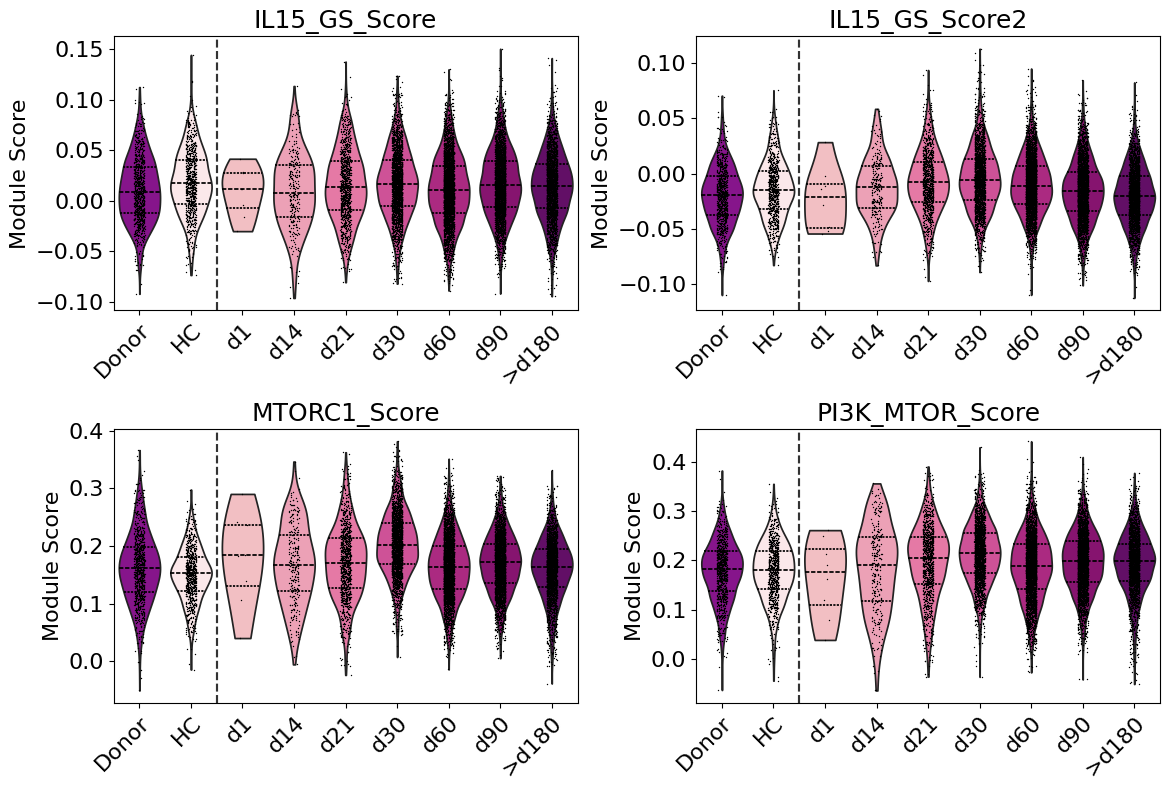

In [30]:
genesets = ['IL15_GS_Score', 'IL15_GS_Score2', 'MTORC1_Score', 'PI3K_MTOR_Score']

# 1. Create the 2x2 grid of axes BEFORE the loop
# We set sharey=True so all plots have the same y-axis scale for easy comparison
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11.8, 8), sharey=False)

# 2. Loop through a 'zip' of your gene sets AND the flattened axes
# axes.flatten() turns the 2x2 grid into a simple 1D list [ax1, ax2, ax3, ax4]
for gs, ax in zip(genesets, axes.flatten()):
    
    # 3. Tell scanpy to plot on the CURRENT axis (ax=ax)
    sc.pl.violin(
        NK_ad, 
        groupby='Time', 
        keys=gs, 
        inner='quart', 
        inner_kws={'color':'black'}, 
        show=False,  # This is crucial!
        ax=ax         # This is the most important fix
    )

    # 4. All your styling code now applies to the current 'ax'
    
    # Add a vertical dashed line
    ax.axvline(
        x=1.5,
        color='black',
        linestyle='--',
        linewidth=1.55,
        alpha=0.8
    )

    # Adjust font sizes
    # sc.pl.violin puts the gene set name in the title
    ax.set_title(gs, fontsize=18) 

    # Adjust x-axis label
    ax.set_xlabel('')

    # Adjust y-axis label
    # I set this to 'Module Score' instead of blank, but you can change it back!
    ax.set_ylabel('Module Score', fontsize=16) 
    
    # Adjust tick label sizes
    ax.tick_params(axis='x', labelsize=16, rotation=45) # For x-ticks
    ax.tick_params(axis='y', labelsize=16) # For y-ticks
    
    # This aligns the *right* side of the label to the tick
    plt.setp(
        ax.get_xticklabels(), 
        ha='right',           # Set horizontal alignment to 'right'
        rotation_mode='anchor' # Rotate around the alignment point
    )     

# 5. NOW, outside the loop, we clean up and show the final figure
plt.tight_layout() # Prevents labels from overlapping
plt.savefig('figures/Time_Violins_2x2.png', dpi=300, bbox_inches='tight')
plt.show()

In [29]:
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler

# --- 1. Prepare Data ---
df = NK_ad.obs.copy()

# Select columns
df_analysis = df[['Patient', 'Time', 'IL15_GS_Score', 'IL15_GS_Score2', 'MTORC1_Score', 'PI3K_MTOR_Score']].rename(columns={
    'Patient': 'PatientID',
    'Time': 'GroupTime',
    'IL15_GS_Score': 'IL15_Score1',
    'IL15_GS_Score2': 'IL15_Score2',
    'MTORC1_Score' : 'mTOR_Score1',
    'PI3K_MTOR_Score' : 'mTOR_Score2'
})

# --- 2. THE FIX: Z-Score the Scores ---
# This puts all scores on a scale of ~ -3 to +3, which fixes convergence issues
scaler = StandardScaler()
score_cols = ['IL15_Score1', 'IL15_Score2', 'mTOR_Score1', 'mTOR_Score2']
df_analysis[score_cols] = scaler.fit_transform(df_analysis[score_cols])

# --- 3. Order Time (Your Logic) ---
def get_time_sort_key(time_str):
    if time_str == 'Donor': return -2
    if time_str == 'HC': return -1
    if '>' in time_str: return 999
    return int(time_str.strip('d'))

all_group_times = df_analysis['GroupTime'].unique().tolist()
final_category_order = sorted(all_group_times, key=get_time_sort_key)

df_analysis['GroupTime'] = pd.Categorical(
    df_analysis['GroupTime'],
    categories=final_category_order,
    ordered=False
)

# --- 4. The Robust Fitting Function ---
def fit_lmm(formula, df):
    print(f"Fitting: {formula}")
    model = smf.mixedlm(formula, data=df, groups=df["PatientID"])
    # We use method='reml' (Restricted Maximum Likelihood) which is often more stable
    # We increase maxiter to give the solver more time
    result = model.fit(reml=True, maxiter=5000)
    print(result.summary())
    return result

# --- 5. Run Models ---
# Now we can just call our robust function
res1 = fit_lmm("IL15_Score1 ~ GroupTime", df_analysis)
print("-" * 50)
res2 = fit_lmm("IL15_Score2 ~ GroupTime", df_analysis)
print("-" * 50)
res3 = fit_lmm("mTOR_Score1 ~ GroupTime", df_analysis)
print("-" * 50)
res4 = fit_lmm("mTOR_Score2 ~ GroupTime", df_analysis)

Fitting: IL15_Score1 ~ GroupTime
            Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  IL15_Score1
No. Observations:   15306    Method:              REML       
No. Groups:         22       Scale:               0.9613     
Min. group size:    10       Log-Likelihood:      -21460.6961
Max. group size:    4458     Converged:           Yes        
Mean group size:    695.7                                    
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          -0.172    0.090 -1.918 0.055 -0.348  0.004
GroupTime[T.HC]     0.160    0.185  0.862 0.389 -0.204  0.523
GroupTime[T.d1]     0.332    0.368  0.901 0.367 -0.390  1.054
GroupTime[T.d14]   -0.116    0.133 -0.871 0.384 -0.377  0.145
GroupTime[T.d21]    0.195    0.123  1.595 0.111 -0.045  0.436
GroupTime[T.d30]    0.359    0.120  2.984 0.003  

/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


#### Figure 7F

In [42]:
#Extract the Pyscenic AUC scores from .obsm
scenic_acts = dc.get_acts(NK_ad, obsm_key='Pyscenic_AUC')

#perform differential regulon expression for plotting
sc.tl.rank_genes_groups(scenic_acts, 
                        groupby='Time', 
                        groups=['d1', 'd14', 'd21', 'd30', 'd60', 'd90', '>d180'], 
                        method='wilcoxon',
                        corr_method='benjamini-hochberg', 
                        use_raw=False
                       )

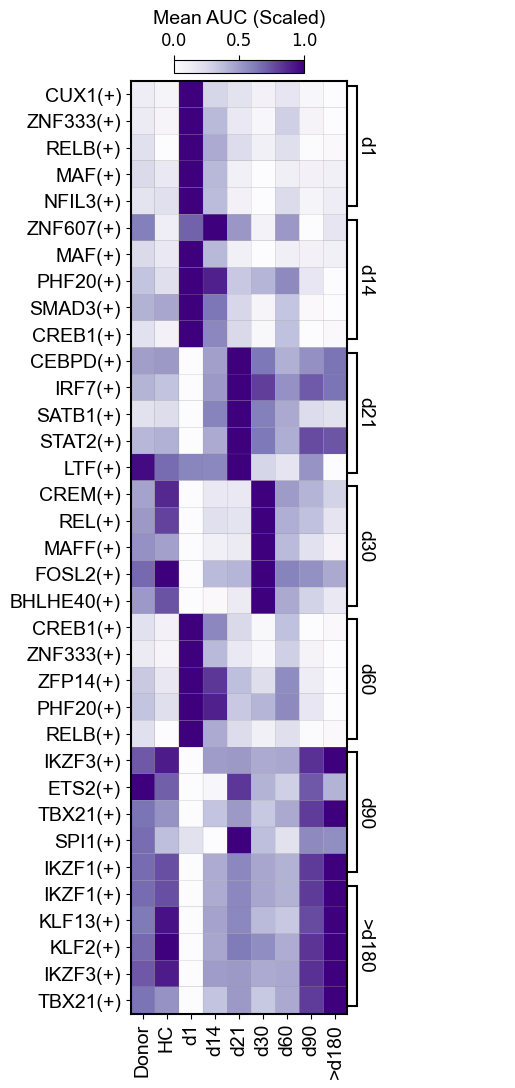

In [44]:
# 1. Create the Matrix Plot
# Note: matrixplot returns a dictionary of axes
mp = sc.pl.rank_genes_groups_matrixplot(
    scenic_acts, 
    groupby='Time', 
    standard_scale='var', 
    n_genes=5, 
    swap_axes=True,
    cmap='Purples',
    dendrogram=False,
    show=False           # Prevent premature display
)

# 2. Get the figure and axes objects
# Matrixplot structure is slightly different than a dotplot: 'mainplot_ax' and 'color_legend_ax'
fig = mp['mainplot_ax'].get_figure()
ax_main = mp['mainplot_ax']
ax_color_legend = mp['color_legend_ax']
ax_categories = mp['gene_group_ax']

# 3. Apply font styling
# Set font for x-axis labels ('Time' groups)
for label in ax_main.get_xticklabels():
    label.set_fontsize(14)
    label.set_fontname('Arial')
    label.set_rotation(90) # Matrix plots often need rotation for x-labels

# Set font for y-axis labels (Regulon names)
for label in ax_main.get_yticklabels():
    label.set_fontsize(14)
    label.set_fontname('Arial')

# Set font for the category groupings on the side
for label in ax_categories.texts:
    label.set_fontsize(14)
    label.set_fontname('Arial')

# --- 4. Reposition the plot and legend ---
# Get original positions
orig_main_pos = ax_main.get_position()
orig_color_leg_pos = ax_color_legend.get_position()

# A. Make space at the top
fig.subplots_adjust(top=0.85) 

# B. Move the Color Legend to the top (Horizontal bar)
# Matrix plots usually have a vertical color bar by default on the right. 
# We can move it to the top to match your previous style.

new_y_pos = 0.82
color_leg_width = orig_main_pos.width * 0.6 
color_leg_height = 0.01 # Make it thin

ax_color_legend.set_position([
    orig_main_pos.x0 + (orig_main_pos.width / 2) - (color_leg_width / 2), # Center it
    new_y_pos,
    color_leg_width,
    color_leg_height
])

# --- 5. Legend Styling ---
ax_color_legend.set_title('Mean AUC (Scaled)', fontsize=14, fontname='Arial')
# Move title to top of the colorbar
ax_color_legend.xaxis.set_ticks_position('top')
ax_color_legend.xaxis.set_label_position('top')
ax_color_legend.tick_params(labelsize=12)

# 6. Save and Show
plt.savefig('figures/differential_regulons_matrixplot.png', dpi=300, bbox_inches='tight')
plt.show()

#### Figure 7G-H

##### PB Stage 4b (CD56bright) comparison (Figure 7G)

In [3]:
IL15_gene_set_2 = [
    'ABCF2', 'AGK', 'ALG3', 'ANKLE1', 'APOO', 'ARHGAP11A', 'ARL6', 'ARPC4', 
    'ASF1B', 'ATAD2', 'ATAD5', 'ATIC', 'AURKA', 'BIRC5', 'BRCA1', 'BRCC3', 
    'BABAM2', 'BZW2', 'L3HYPDH', 'NOP9', 'ENKD1', 'RUSF1', 'HROB', 'TIMM21', 
    'FAM174C', 'CMSS1', 'C5orf15', 'ARMT1', 'CARNMT1', 'CALU', 'CCNA2', 'CDC123', 
    'CDC25A', 'CDC25C', 'CDC45', 'CDC6', 'CDCA2', 'CDK7', 'CDKN2C', 'CENPF', 
    'CENPJ', 'CETN3', 'CHADL', 'CINP', 'UTP4', 'CIT', 'CKAP2L', 'CLSPN', 
    'COMMD10', 'COPS5', 'CRLS1', 'CRTAP', 'CTR9', 'DDX20', 'DEPDC1B', 'DGCR6', 
    'DKC1', 'DNA2', 'DPAGT1', 'DUS2', 'E2F3', 'E2F8', 'ECE2', 'EIF1AD', 
    'ELAVL1', 'EME1', 'ERRFI1', 'EXOSC2', 'EZH2', 'FAM111A', 'FMR1', 'CMTR1', 
    'GEMIN4', 'GMPR2', 'GOT1', 'ADGRG3', 'GPSM2', 'GRWD1', 'GSTCD', 'HAUS1', 
    'HAUS5', 'HAUS6', 'HAUS7', 'HDAC3', 'HELLS', 'HELQ', 'HNRNPH2', 'HSD17B7', 
    'HSPA14', 'IARS1', 'ILF2', 'IPP', 'PCLAF', 'FAM234B', 'KIF20B', 'KIFC1', 
    'KPNA1', 'LAP3', 'LSM5', 'MAGOHB', 'MASTL', 'MBD4', 'MBNL3', 'MCM3', 
    'MEMO1', 'METAP2', 'METTL14', 'MID1IP1', 'MIS12', 'MOAP1', 'MPHOSPH10', 
    'MRPS18B', 'MTBP', 'MTFP1', 'MTHFD2', 'MVD', 'MYBL2', 'MYCN', 'NANP', 
    'NAT10', 'NBN', 'NCAPG', 'NEK2', 'NFX1', 'NOP2', 'NQO1', 'NUBPL', 'NUSAP1', 
    'OSGIN2', 'PARP2', 'PATL1', 'PCGF6', 'PIM2', 'PKM', 'PLAA', 'PLK4', 
    'PLRG1', 'POLE3', 'POLR3E', 'POLR3G', 'PPAT', 'PPP5C', 'PRKAR2A', 'PRPS1', 
    'PTGER3', 'PUS3', 'RAD1', 'RAD54L', 'RBMX2', 'RCC2', 'RGS16', 'MRM3', 
    'RPP40', 'SAE1', 'SCARB1', 'SEMA6D', 'SLC25A1', 'SLC29A1', 'SLC31A1', 
    'SLC7A5', 'SLC9A2', 'SNX7', 'SOCS1', 'SPRED1', 'STK39', 'SYNCRIP', 
    'TARDBP', 'TBC1D7', 'ALYREF', 'THUMPD2', 'THYN1', 'TIMM10', 'TIMM9', 
    'TM9SF4', 'TMEM101', 'TMEM107', 'TMEM201', 'TMEM39A', 'TMEM97', 'TOP2A', 
    'TP53RK', 'TRIAP1', 'TSPAN4', 'TYMS', 'UAP1', 'UBE2C', 'UBFD1', 'BLTP3A', 
    'UMPS', 'URB1', 'USP5', 'RCC1L', 'WDR4', 'WDR43', 'WDR74', 'WDR89', 
    'WEE1', 'XRCC3', 'ZWILCH', 'ZWINT'
]

hallmark_mtorc1 = [
    'ABCF2', 'ACACA', 'ACLY', 'ACSL3', 'ACTR2', 'ACTR3', 'ADD3', 'ADIPOR2', 
    'AK4', 'ALDOA', 'ARPC5L', 'ASNS', 'ATP2A2', 'ATP5MC1', 'ATP6V1D', 'AURKA', 
    'BCAT1', 'BHLHE40', 'BTG2', 'BUB1', 'CACYBP', 'CALR', 'CANX', 'CCNF', 
    'CCNG1', 'CCT6A', 'CD9', 'CDC25A', 'CDKN1A', 'CFP', 'COPS5', 'CORO1A', 
    'CTH', 'CTSC', 'CXCR4', 'CYB5B', 'CYP51A1', 'DAPP1', 'DDIT3', 'DDIT4', 
    'DDX39A', 'DHCR24', 'DHCR7', 'DHFR', 'EBP', 'EDEM1', 'EEF1E1', 'EGLN3', 
    'EIF2S2', 'ELOVL5', 'ELOVL6', 'ENO1', 'EPRS1', 'ERO1A', 'ETF1', 'FADS1', 
    'FADS2', 'NIBAN1', 'FDXR', 'FGL2', 'FKBP2', 'G6PD', 'GAPDH', 'GBE1', 
    'GCLC', 'GGA2', 'GLA', 'GLRX', 'GMPS', 'GOT1', 'GPI', 'GSK3B', 'GSR', 
    'GTF2H1', 'HK2', 'HMBS', 'HMGCR', 'HMGCS1', 'HPRT1', 'HSP90B1', 'HSPA4', 
    'HSPA5', 'HSPA9', 'HSPD1', 'HSPE1', 'IDH1', 'IDI1', 'IFI30', 'IFRD1', 
    'IGFBP5', 'IMMT', 'INSIG1', 'ITGB2', 'LDHA', 'LDLR', 'LGMN', 'LTA4H', 
    'M6PR', 'MAP2K3', 'MCM2', 'MCM4', 'ME1', 'MLLT11', 'MTHFD2', 'MTHFD2L', 
    'NAMPT', 'NFIL3', 'NFKBIB', 'NFYC', 'NMT1', 'NUFIP1', 'NUP205', 'NUPR1', 
    'P4HA1', 'PDAP1', 'PDK1', 'PFKL', 'PGK1', 'PGM1', 'PHGDH', 'PIK3R3', 
    'PITPNB', 'PLK1', 'PLOD2', 'PNO1', 'PNP', 'POLR3G', 'PPA1', 'PPIA', 
    'PPP1R15A', 'PRDX1', 'PSAT1', 'PSMA3', 'PSMA4', 'PSMB5', 'PSMC2', 'PSMC4', 
    'PSMC6', 'PSMD12', 'PSMD13', 'PSMD14', 'PSME3', 'PSMG1', 'PSPH', 'QDPR', 
    'RAB1A', 'RDH11', 'RIT1', 'RPA1', 'RPN1', 'RRM2', 'RRP9', 'SC5D', 'SCD', 
    'SDF2L1', 'SEC11A', 'SERP1', 'SERPINH1', 'SHMT2', 'SKAP2', 'SLA', 'SLC1A4', 
    'SLC1A5', 'SLC2A1', 'SLC2A3', 'SLC37A4', 'SLC6A6', 'SLC7A11', 'SLC7A5', 
    'NHERF1', 'SORD', 'SQLE', 'SQSTM1', 'SRD5A1', 'SSR1', 'STARD4', 'STC1', 
    'STIP1', 'SYTL2', 'TBK1', 'TCEA1', 'TES', 'TFRC', 'TM7SF2', 'TMEM97', 
    'TOMM40', 'TPI1', 'TRIB3', 'TUBA4A', 'TUBG1', 'TXNRD1', 'UBE2D3', 'UCHL5', 
    'UFM1', 'UNG', 'USO1', 'VLDLR', 'WARS1', 'XBP1', 'YKT6'
]

In [6]:
# Subset 1: NK_ad
mask_nk = (
    ((NK_ad.obs['Time'] == 'd30') | (NK_ad.obs['Time'] == 'Donor' ) | (NK_ad.obs['Time'] == 'HC')) &
    (NK_ad.obs['leiden_res_0.4'] == '4')
)
NK_ad_subset = NK_ad[mask_nk, :].copy() # .copy() is recommended to avoid View warnings
print(f"\nFound {NK_ad_subset.n_obs} cells from NK_ad")


Found 871 cells from NK_ad


In [7]:
sc.tl.score_genes(NK_ad_subset, gene_list=IL15_gene_set_2, score_name='IL15_Score', use_raw=False, layer='log_counts')
sc.tl.score_genes(NK_ad_subset, gene_list=hallmark_mtorc1, score_name='mTOR_Score', use_raw=False, layer='log_counts')

In [9]:
# --- Step 3: Create the Pseudo-bulk Matrices ---

# --- 1. Create the Counts Matrix (counts_df) ---
# We need a DataFrame with cells as rows and genes as columns

# DEFINE YOUR LAYER HERE
layer_name = 'log_counts'  

# Check if the specific layer is sparse and convert if necessary
if scipy.sparse.issparse(NK_ad_subset.layers[layer_name]):
    counts_matrix = NK_ad_subset.layers[layer_name].toarray()
else:
    counts_matrix = NK_ad_subset.layers[layer_name]

counts_df = pd.DataFrame(
    data=counts_matrix,
    index=NK_ad_subset.obs_names,
    columns=NK_ad_subset.var_names
)

# Add the 'Patient' column to the DataFrame for grouping
counts_df['Patient'] = NK_ad_subset.obs['Patient'].values

# Group by 'Patient' and sum all counts
# This creates the correct (samples, genes) shape
pb_counts_df = counts_df.groupby('Patient').sum()

# IMPORTANT: pydeseq2 requires INTEGER counts
pb_counts_df = pb_counts_df.astype(int)


# --- 2. Create the Metadata (colData) ---
# We need a metadata table where the rows match the rows of our counts matrix
# The 'Patient' column is our sample ID
# The 'Time' column is our condition
metadata_df = NK_ad_subset.obs[['Patient', 'Time']].drop_duplicates().set_index('Patient')

# Ensure the metadata rows are in the *exact same order* as the counts rows
# Align to the .index (patients)
metadata_df = metadata_df.loc[pb_counts_df.index]

# Verify shapes match
print(f"Counts shape: {pb_counts_df.shape}")
print(f"Metadata shape: {metadata_df.shape}")

Counts shape: (20, 33538)
Metadata shape: (20, 1)


In [10]:
# --- Step 4 : Run pydeseq2 ---
inference = DefaultInference(n_cpus=16)

# 1. Initialize the DeseqDataSet (with the new design argument)
dds = DeseqDataSet(
    counts=pb_counts_df,
    metadata=metadata_df,
    refit_cooks=True,
    inference=inference,
    design="~ Time"
)

# 2. Run the DESeq2 pipeline
dds.deseq2()

# 3. Get the results
stat_res_donor = DeseqStats(dds, contrast=['Time', 'd30', 'Donor'])
stat_res_hc = DeseqStats(dds, contrast=['Time', 'd30', 'HC'])

# 4.Get the DataFrame from the .results_df attribute
stat_res_donor.summary()
res_df_donor = stat_res_donor.results_df

stat_res_hc.summary()
res_df_hc = stat_res_hc.results_df

# --- Step 5 Get Your Ranked List for GSEA ---

# 6. Now .dropna() will work!
# This correctly removes all genes with 'NaN' (usually from 0 counts)
res_df_donor = res_df_donor.dropna()
res_df_hc = res_df_hc.dropna()

# 7. Sort the results by the 'stat' column
donor_gene_list = res_df_donor.sort_values(by='stat', ascending=False)
hc_gene_list = res_df_hc.sort_values(by='stat', ascending=False)

print("\nRanked Gene List Head:")
print(donor_gene_list.head())
print(hc_gene_list.head())

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 1.37 seconds.

Fitting dispersion trend curve...
/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:822: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.27 seconds.

Fitting MAP dispersions...
... done in 1.56 seconds.

Fitting LFCs...
... done in 1.45 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 6 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...
... done in 56.98 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: Time d30 vs Donor
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
MIR1302-2HG  0.000000             NaN       NaN       NaN       NaN       NaN
FAM138A      0.000000             NaN       NaN       NaN       NaN       NaN
OR4F5        0.000000             NaN       NaN       NaN       NaN       NaN
AL627309.1   0.015473       -2.572598  3.491602 -0.736796  0.461247  0.759928
AL627309.3   0.000000             NaN       NaN       NaN       NaN       NaN
...               ...             ...       ...       ...       ...       ...
AC233755.2   0.000000             NaN       NaN       NaN       NaN       NaN
AC233755.1   0.000000             NaN       NaN       NaN       NaN       NaN
AC240274.1   0.000000             NaN       NaN       NaN       NaN       NaN
AC213203.1   0.000000             NaN       NaN       NaN       NaN       NaN
FAM231C      0.000000             NaN       NaN       NaN       NaN       NaN

[33538 

... done in 1.98 seconds.



In [11]:
# Create the master gene set dictionary
gene_set_dict = {
    '1_IL15_Prolif_Sig': IL15_gene_set_2,
    '2_mTOR_Sig': hallmark_mtorc1
}

# Get the list of gene set names in the order we want
geneset_names_ordered = sorted(gene_set_dict.keys())

In [12]:
# We assume 'transplant_gene_list_df' has genes as the index and a 'stat' column
rank_list_donor = donor_gene_list['stat'].sort_values(ascending=False)
rank_list_donor = rank_list_donor.dropna() # Remove any NaN genes

rank_list_hc = hc_gene_list['stat'].sort_values(ascending=False)
rank_list_hc = rank_list_hc.dropna() # Remove any NaN genes

In [13]:
# (Assuming your ranked_lists_to_run and phenotype_labels dicts are defined)
ranked_lists_to_run = {
    'd30_vs_Donor': rank_list_donor,
    'd30_vs_HC': rank_list_hc
}

phenotype_labels = {
    'd30_vs_Donor': {'pos': 'd30', 'neg': 'Donor'},
    'd30_vs_HC': {'pos': 'd30', 'neg': 'HC'},
}

output_dir = 'gsea_figures/CD56_Bright'

# We will save filenames in the 2x2 order
filename_grid = [[None, None], [None, None]] # 2x2 grid

print("Starting GSEA plot generation...")

for i, (list_name, rnk_list) in enumerate(ranked_lists_to_run.items()):
    
    labels = phenotype_labels[list_name]
    
    for j, set_name in enumerate(geneset_names_ordered):
        
        current_gene_set = {set_name: gene_set_dict[set_name]}

        pr_result = gseapy.prerank(
            rnk=rnk_list,
            gene_sets=current_gene_set,
            min_size=10, 
            seed=42
        )
        
        result_key = list(pr_result.results.keys())[0]

        # 1. Call gseaplot, which returns a LIST of axes
        gseaplot_return_list = gseapy.gseaplot(
            rank_metric=rnk_list, 
            term=result_key,
            **pr_result.results[result_key],
            legend_loc='upper right'
        )
        
        # 2. Get the actual axis object *from* the list
        ax_plot = gseaplot_return_list[0] 
        
        # 3. Get the figure object *from* the axis
        fig_plot = ax_plot.get_figure()

        # 4. Now, apply all our custom formatting to THAT axis
        nes = pr_result.results[result_key]['nes']
        pval = pr_result.results[result_key]['pval']
        
        ax_plot.set_title(
            f"{set_name.split('_', 1)[1]}\nNES = {nes:.2f} | p-val = {pval:.3f}",
            fontsize=24,
            wrap=True 
        )
        ax_plot.set_ylabel(list_name, fontsize=16, fontweight='bold')
        ax_plot.text(0.05, 0.05, s=labels['pos'], ha='left', fontsize=20, fontweight='bold', transform=ax_plot.transAxes)
        ax_plot.text(0.95, 0.05, s=labels['neg'], ha='right', fontsize=20, fontweight='bold', transform=ax_plot.transAxes)
        ax_plot.set_xlabel('Gene Rank', fontsize=20)

        # 5. Save the figure that gseaplot created
        filename = f"{i}_{j}__{list_name}__{set_name}.png"
        filepath = os.path.join(output_dir, filename)
        
        fig_plot.savefig(filepath, dpi=150, bbox_inches='tight')
        
        # 6. Close THAT figure
        plt.close(fig_plot)
        
        # Store the filename in our grid for the next step
        filename_grid[i][j] = filepath
        
print(f"Individual GSEA plots saved to '{output_dir}'.")

2026-02-05 13:54:52,689 [WARNING] Duplicated values found in preranked stats: 21.05% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Starting GSEA plot generation...


2026-02-05 13:54:53,775 [WARNING] Duplicated values found in preranked stats: 21.05% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2026-02-05 13:54:54,758 [WARNING] Duplicated values found in preranked stats: 21.07% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2026-02-05 13:54:55,745 [WARNING] Duplicated values found in preranked stats: 21.07% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Individual GSEA plots saved to 'gsea_figures/CD56_Bright'.


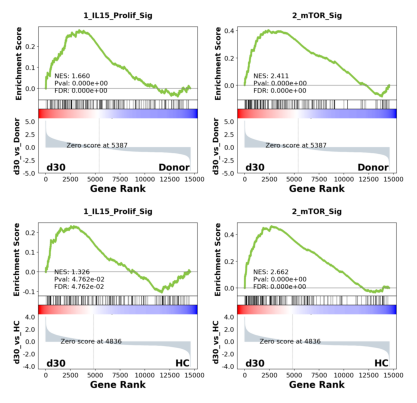

In [14]:
# Create the 2x2 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(4, 4)) # (W, H)

for i in range(2): # Rows
    for j in range(2): # Columns
        
        # Load the saved image from the correct grid position
        img = plt.imread(filename_grid[i][j])
        
        # Display the image in the correct subplot
        axes[i, j].imshow(img)
        
        # Turn off the axis ticks and labels
        axes[i, j].axis('off')

# Clean up the layout (use a light pad to avoid images touching)
plt.tight_layout(pad=0.1) 
plt.savefig(os.path.join(output_dir, 'GSEA_Grid_2x2_FINAL.png'), dpi=300)
plt.show()

##### PB Stage 5/6 (CD56dim) comparison (Figure 7H)

In [15]:
IL15_gene_set_2 = [
    'ABCF2', 'AGK', 'ALG3', 'ANKLE1', 'APOO', 'ARHGAP11A', 'ARL6', 'ARPC4', 
    'ASF1B', 'ATAD2', 'ATAD5', 'ATIC', 'AURKA', 'BIRC5', 'BRCA1', 'BRCC3', 
    'BABAM2', 'BZW2', 'L3HYPDH', 'NOP9', 'ENKD1', 'RUSF1', 'HROB', 'TIMM21', 
    'FAM174C', 'CMSS1', 'C5orf15', 'ARMT1', 'CARNMT1', 'CALU', 'CCNA2', 'CDC123', 
    'CDC25A', 'CDC25C', 'CDC45', 'CDC6', 'CDCA2', 'CDK7', 'CDKN2C', 'CENPF', 
    'CENPJ', 'CETN3', 'CHADL', 'CINP', 'UTP4', 'CIT', 'CKAP2L', 'CLSPN', 
    'COMMD10', 'COPS5', 'CRLS1', 'CRTAP', 'CTR9', 'DDX20', 'DEPDC1B', 'DGCR6', 
    'DKC1', 'DNA2', 'DPAGT1', 'DUS2', 'E2F3', 'E2F8', 'ECE2', 'EIF1AD', 
    'ELAVL1', 'EME1', 'ERRFI1', 'EXOSC2', 'EZH2', 'FAM111A', 'FMR1', 'CMTR1', 
    'GEMIN4', 'GMPR2', 'GOT1', 'ADGRG3', 'GPSM2', 'GRWD1', 'GSTCD', 'HAUS1', 
    'HAUS5', 'HAUS6', 'HAUS7', 'HDAC3', 'HELLS', 'HELQ', 'HNRNPH2', 'HSD17B7', 
    'HSPA14', 'IARS1', 'ILF2', 'IPP', 'PCLAF', 'FAM234B', 'KIF20B', 'KIFC1', 
    'KPNA1', 'LAP3', 'LSM5', 'MAGOHB', 'MASTL', 'MBD4', 'MBNL3', 'MCM3', 
    'MEMO1', 'METAP2', 'METTL14', 'MID1IP1', 'MIS12', 'MOAP1', 'MPHOSPH10', 
    'MRPS18B', 'MTBP', 'MTFP1', 'MTHFD2', 'MVD', 'MYBL2', 'MYCN', 'NANP', 
    'NAT10', 'NBN', 'NCAPG', 'NEK2', 'NFX1', 'NOP2', 'NQO1', 'NUBPL', 'NUSAP1', 
    'OSGIN2', 'PARP2', 'PATL1', 'PCGF6', 'PIM2', 'PKM', 'PLAA', 'PLK4', 
    'PLRG1', 'POLE3', 'POLR3E', 'POLR3G', 'PPAT', 'PPP5C', 'PRKAR2A', 'PRPS1', 
    'PTGER3', 'PUS3', 'RAD1', 'RAD54L', 'RBMX2', 'RCC2', 'RGS16', 'MRM3', 
    'RPP40', 'SAE1', 'SCARB1', 'SEMA6D', 'SLC25A1', 'SLC29A1', 'SLC31A1', 
    'SLC7A5', 'SLC9A2', 'SNX7', 'SOCS1', 'SPRED1', 'STK39', 'SYNCRIP', 
    'TARDBP', 'TBC1D7', 'ALYREF', 'THUMPD2', 'THYN1', 'TIMM10', 'TIMM9', 
    'TM9SF4', 'TMEM101', 'TMEM107', 'TMEM201', 'TMEM39A', 'TMEM97', 'TOP2A', 
    'TP53RK', 'TRIAP1', 'TSPAN4', 'TYMS', 'UAP1', 'UBE2C', 'UBFD1', 'BLTP3A', 
    'UMPS', 'URB1', 'USP5', 'RCC1L', 'WDR4', 'WDR43', 'WDR74', 'WDR89', 
    'WEE1', 'XRCC3', 'ZWILCH', 'ZWINT'
]

hallmark_mtorc1 = [
    'ABCF2', 'ACACA', 'ACLY', 'ACSL3', 'ACTR2', 'ACTR3', 'ADD3', 'ADIPOR2', 
    'AK4', 'ALDOA', 'ARPC5L', 'ASNS', 'ATP2A2', 'ATP5MC1', 'ATP6V1D', 'AURKA', 
    'BCAT1', 'BHLHE40', 'BTG2', 'BUB1', 'CACYBP', 'CALR', 'CANX', 'CCNF', 
    'CCNG1', 'CCT6A', 'CD9', 'CDC25A', 'CDKN1A', 'CFP', 'COPS5', 'CORO1A', 
    'CTH', 'CTSC', 'CXCR4', 'CYB5B', 'CYP51A1', 'DAPP1', 'DDIT3', 'DDIT4', 
    'DDX39A', 'DHCR24', 'DHCR7', 'DHFR', 'EBP', 'EDEM1', 'EEF1E1', 'EGLN3', 
    'EIF2S2', 'ELOVL5', 'ELOVL6', 'ENO1', 'EPRS1', 'ERO1A', 'ETF1', 'FADS1', 
    'FADS2', 'NIBAN1', 'FDXR', 'FGL2', 'FKBP2', 'G6PD', 'GAPDH', 'GBE1', 
    'GCLC', 'GGA2', 'GLA', 'GLRX', 'GMPS', 'GOT1', 'GPI', 'GSK3B', 'GSR', 
    'GTF2H1', 'HK2', 'HMBS', 'HMGCR', 'HMGCS1', 'HPRT1', 'HSP90B1', 'HSPA4', 
    'HSPA5', 'HSPA9', 'HSPD1', 'HSPE1', 'IDH1', 'IDI1', 'IFI30', 'IFRD1', 
    'IGFBP5', 'IMMT', 'INSIG1', 'ITGB2', 'LDHA', 'LDLR', 'LGMN', 'LTA4H', 
    'M6PR', 'MAP2K3', 'MCM2', 'MCM4', 'ME1', 'MLLT11', 'MTHFD2', 'MTHFD2L', 
    'NAMPT', 'NFIL3', 'NFKBIB', 'NFYC', 'NMT1', 'NUFIP1', 'NUP205', 'NUPR1', 
    'P4HA1', 'PDAP1', 'PDK1', 'PFKL', 'PGK1', 'PGM1', 'PHGDH', 'PIK3R3', 
    'PITPNB', 'PLK1', 'PLOD2', 'PNO1', 'PNP', 'POLR3G', 'PPA1', 'PPIA', 
    'PPP1R15A', 'PRDX1', 'PSAT1', 'PSMA3', 'PSMA4', 'PSMB5', 'PSMC2', 'PSMC4', 
    'PSMC6', 'PSMD12', 'PSMD13', 'PSMD14', 'PSME3', 'PSMG1', 'PSPH', 'QDPR', 
    'RAB1A', 'RDH11', 'RIT1', 'RPA1', 'RPN1', 'RRM2', 'RRP9', 'SC5D', 'SCD', 
    'SDF2L1', 'SEC11A', 'SERP1', 'SERPINH1', 'SHMT2', 'SKAP2', 'SLA', 'SLC1A4', 
    'SLC1A5', 'SLC2A1', 'SLC2A3', 'SLC37A4', 'SLC6A6', 'SLC7A11', 'SLC7A5', 
    'NHERF1', 'SORD', 'SQLE', 'SQSTM1', 'SRD5A1', 'SSR1', 'STARD4', 'STC1', 
    'STIP1', 'SYTL2', 'TBK1', 'TCEA1', 'TES', 'TFRC', 'TM7SF2', 'TMEM97', 
    'TOMM40', 'TPI1', 'TRIB3', 'TUBA4A', 'TUBG1', 'TXNRD1', 'UBE2D3', 'UCHL5', 
    'UFM1', 'UNG', 'USO1', 'VLDLR', 'WARS1', 'XBP1', 'YKT6'
]

In [16]:
# Subset 1: NK_ad
mask_nk = (
    ((NK_ad.obs['Time'] == 'd30') | (NK_ad.obs['Time'] == 'Donor' ) | (NK_ad.obs['Time'] == 'HC')) &
    (NK_ad.obs['leiden_res_0.4'] != '4')
)
NK_ad_subset = NK_ad[mask_nk, :].copy() # .copy() is recommended to avoid View warnings
print(f"\nFound {NK_ad_subset.n_obs} cells from NK_ad")


Found 3339 cells from NK_ad


In [17]:
# --- Step 3: Create the Pseudo-bulk Matrices ---

# --- 1. Create the Counts Matrix (counts_df) ---
# We need a DataFrame with cells as rows and genes as columns

# DEFINE YOUR LAYER HERE
layer_name = 'log_counts'  

# Check if the specific layer is sparse and convert if necessary
if scipy.sparse.issparse(NK_ad_subset.layers[layer_name]):
    counts_matrix = NK_ad_subset.layers[layer_name].toarray()
else:
    counts_matrix = NK_ad_subset.layers[layer_name]

counts_df = pd.DataFrame(
    data=counts_matrix,
    index=NK_ad_subset.obs_names,
    columns=NK_ad_subset.var_names
)

# Add the 'Patient' column to the DataFrame for grouping
counts_df['Patient'] = NK_ad_subset.obs['Patient'].values

# Group by 'Patient' and sum all counts
# This creates the correct (samples, genes) shape
pb_counts_df = counts_df.groupby('Patient').sum()

# IMPORTANT: pydeseq2 requires INTEGER counts
pb_counts_df = pb_counts_df.astype(int)


# --- 2. Create the Metadata (colData) ---
# We need a metadata table where the rows match the rows of our counts matrix
# The 'Patient' column is our sample ID
# The 'Time' column is our condition
metadata_df = NK_ad_subset.obs[['Patient', 'Time']].drop_duplicates().set_index('Patient')

# Ensure the metadata rows are in the *exact same order* as the counts rows
# Align to the .index (patients)
metadata_df = metadata_df.loc[pb_counts_df.index]

# Verify shapes match
print(f"Counts shape: {pb_counts_df.shape}")
print(f"Metadata shape: {metadata_df.shape}")

Counts shape: (21, 33538)
Metadata shape: (21, 1)


In [18]:
# --- Step 4 : Run pydeseq2 ---
inference = DefaultInference(n_cpus=16)

# 1. Initialize the DeseqDataSet (with the new design argument)
dds = DeseqDataSet(
    counts=pb_counts_df,
    metadata=metadata_df,
    refit_cooks=True,
    inference=inference,
    design="~ Time"  # Using the newer 'design' argument instead of 'design_factors'
)

# 2. Run the DESeq2 pipeline
dds.deseq2()

# 3. Get the results
stat_res_donor = DeseqStats(dds, contrast=['Time', 'd30', 'Donor'])
stat_res_hc = DeseqStats(dds, contrast=['Time', 'd30', 'HC'])

# 4.Get the DataFrame from the .results_df attribute
stat_res_donor.summary()
res_df_donor = stat_res_donor.results_df

stat_res_hc.summary()
res_df_hc = stat_res_hc.results_df

# --- Step 5 Get Your Ranked List for GSEA ---

# 6. Now .dropna() will work!
# This correctly removes all genes with 'NaN' (usually from 0 counts)
res_df_donor = res_df_donor.dropna()
res_df_hc = res_df_hc.dropna()

# 7. Sort the results by the 'stat' column
donor_gene_list = res_df_donor.sort_values(by='stat', ascending=False)
hc_gene_list = res_df_hc.sort_values(by='stat', ascending=False)

print("\nRanked Gene List Head:")
print(donor_gene_list.head())
print(hc_gene_list.head())

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 1.06 seconds.

Fitting dispersion trend curve...
/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:822: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.32 seconds.

Fitting MAP dispersions...
... done in 1.38 seconds.

Fitting LFCs...
... done in 1.80 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 29 outlier genes.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.02 seconds.

Running Wald tests...
... done in 3.10 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: Time d30 vs Donor
             baseMean  log2FoldChange     lfcSE      stat    pvalue  padj
MIR1302-2HG  0.000000             NaN       NaN       NaN       NaN   NaN
FAM138A      0.000000             NaN       NaN       NaN       NaN   NaN
OR4F5        0.000000             NaN       NaN       NaN       NaN   NaN
AL627309.1   0.154601       -0.561319  2.158474 -0.260054  0.794822   NaN
AL627309.3   0.000000             NaN       NaN       NaN       NaN   NaN
...               ...             ...       ...       ...       ...   ...
AC233755.2   0.000000             NaN       NaN       NaN       NaN   NaN
AC233755.1   0.000000             NaN       NaN       NaN       NaN   NaN
AC240274.1   0.000000             NaN       NaN       NaN       NaN   NaN
AC213203.1   0.000000             NaN       NaN       NaN       NaN   NaN
FAM231C      0.000000             NaN       NaN       NaN       NaN   NaN

[33538 rows x 6 columns]
Log2 fold change & Wald test p

... done in 2.22 seconds.



In [19]:
# Create the master gene set dictionary
gene_set_dict = {
    '1_IL15_Prolif_Sig': IL15_gene_set_2,
    '2_mTOR_Sig': hallmark_mtorc1
}

# Get the list of gene set names in the order we want
geneset_names_ordered = sorted(gene_set_dict.keys())

In [20]:
# We assume 'transplant_gene_list_df' has genes as the index and a 'stat' column
rank_list_donor = donor_gene_list['stat'].sort_values(ascending=False)
rank_list_donor = rank_list_donor.dropna() # Remove any NaN genes

rank_list_hc = hc_gene_list['stat'].sort_values(ascending=False)
rank_list_hc = rank_list_hc.dropna() # Remove any NaN genes

In [21]:
# (Assuming your ranked_lists_to_run and phenotype_labels dicts are defined)
ranked_lists_to_run = {
    'd30_vs_Donor': rank_list_donor,
    'd30_vs_HC': rank_list_hc
}

phenotype_labels = {
    'd30_vs_Donor': {'pos': 'd30', 'neg': 'Donor'},
    'd30_vs_HC': {'pos': 'd30', 'neg': 'HC'},
}

output_dir = 'gsea_figures/CD56_Dim'

# We will save filenames in the 2x2 order
filename_grid = [[None, None], [None, None]] # 2x2 grid

print("Starting GSEA plot generation...")

for i, (list_name, rnk_list) in enumerate(ranked_lists_to_run.items()):
    
    labels = phenotype_labels[list_name]
    
    for j, set_name in enumerate(geneset_names_ordered):
        
        current_gene_set = {set_name: gene_set_dict[set_name]}

        pr_result = gseapy.prerank(
            rnk=rnk_list,
            gene_sets=current_gene_set,
            min_size=10, 
            seed=42
        )
        
        result_key = list(pr_result.results.keys())[0]

        # 1. Call gseaplot, which returns a LIST of axes
        gseaplot_return_list = gseapy.gseaplot(
            rank_metric=rnk_list, 
            term=result_key,
            **pr_result.results[result_key],
            legend_loc='upper right'
        )
        
        # 2. Get the actual axis object *from* the list
        ax_plot = gseaplot_return_list[0] 
        
        # 3. Get the figure object *from* the axis
        fig_plot = ax_plot.get_figure()

        # 4. Now, apply all our custom formatting to THAT axis
        nes = pr_result.results[result_key]['nes']
        pval = pr_result.results[result_key]['pval']
        
        ax_plot.set_title(
            f"{set_name.split('_', 1)[1]}\nNES = {nes:.2f} | p-val = {pval:.3f}",
            fontsize=24,
            wrap=True 
        )
        ax_plot.set_ylabel(list_name, fontsize=16, fontweight='bold')
        ax_plot.text(0.05, 0.05, s=labels['pos'], ha='left', fontsize=20, fontweight='bold', transform=ax_plot.transAxes)
        ax_plot.text(0.95, 0.05, s=labels['neg'], ha='right', fontsize=20, fontweight='bold', transform=ax_plot.transAxes)
        ax_plot.set_xlabel('Gene Rank', fontsize=20)

        # 5. Save the figure that gseaplot created
        filename = f"{i}_{j}__{list_name}__{set_name}.png"
        filepath = os.path.join(output_dir, filename)
        
        fig_plot.savefig(filepath, dpi=150, bbox_inches='tight')
        
        # 6. Close THAT figure
        plt.close(fig_plot)
        
        # Store the filename in our grid for the next step
        filename_grid[i][j] = filepath
        
print(f"Individual GSEA plots saved to '{output_dir}'.")

Starting GSEA plot generation...
Individual GSEA plots saved to 'gsea_figures/CD56_Dim'.


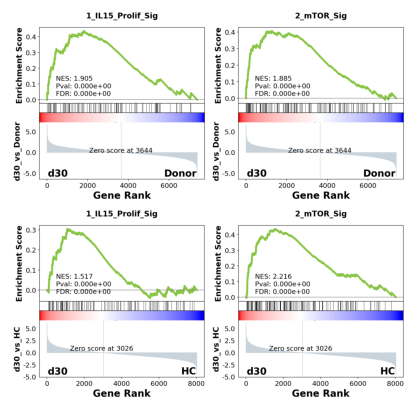

In [22]:
# Create the 2x2 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(4, 4)) # (W, H)

for i in range(2): # Rows
    for j in range(2): # Columns
        
        # Load the saved image from the correct grid position
        img = plt.imread(filename_grid[i][j])
        
        # Display the image in the correct subplot
        axes[i, j].imshow(img)
        
        # Turn off the axis ticks and labels
        axes[i, j].axis('off')

# Clean up the layout (use a light pad to avoid images touching)
plt.tight_layout(pad=0.1) 
plt.savefig(os.path.join(output_dir, 'GSEA_Grid_2x2_FINAL.png'), dpi=300)
plt.show()

#### Figure S7A

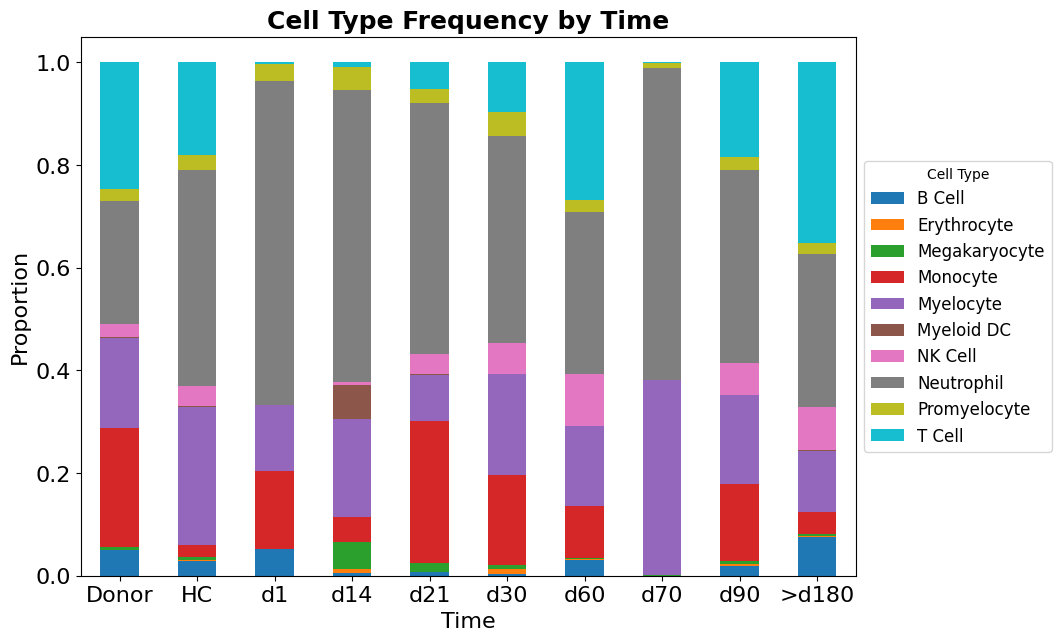

In [83]:
# --- 1. Calculate Proportions ---

# Create a 'crosstab' (a contingency table) of counts
# This gives rows=Time, columns=cell_type, values=cell_count
counts_df = pd.crosstab(TNC_ad.obs['Time'], TNC_ad.obs['celltype'])

# Divide each row (axis=0) by its sum to get proportions (frequency)
proportions_df = counts_df.div(counts_df.sum(axis=1), axis=0)

# You can print it to see what it looks like:
# print(proportions_df.head())
# cell_type      B-cell   DC   Erythrocyte  ...
# Time                                     ...
# D0             0.25   0.15     0.10
# D7             0.10   0.20     0.05
# ...

# --- 2. Create the Stacked Bar Plot ---

# Create the plot
ax = proportions_df.plot(
    kind='bar', 
    stacked=True, 
    figsize=(10, 7)  # (width, height)
)

# --- 3. Customize and Save ---

# Set labels and title
ax.set_title('Cell Type Frequency by Time', fontsize=18, fontweight='bold')
ax.set_ylabel('Proportion', fontsize=16)
ax.set_xlabel('Time', fontsize=16)
ax.tick_params(axis='x', labelsize=16, rotation=0)
ax.tick_params(axis='y', labelsize=16, rotation=0)

# Move the legend outside the plot box
ax.legend(
    title='Cell Type',
    loc='center left', 
    bbox_to_anchor=(1.0, 0.5), # Positions legend to the right
    fontsize=12
)

# Save the figure (using bbox_inches='tight' to prevent cut-off)
plt.savefig('figures/TNC_stacked_bar.png', dpi=300, bbox_inches='tight')
plt.show()

#### Figure S7B-D

In [46]:
# load in li et al tonsil and blood anndata objects
bl_ad = sc.read_h5ad('/users/PAS1800/ruesch6/Single_Cell_Files/Anderson_Blood_NK_RNAseq/Scanpy/singlet_adata.h5ad')

In [74]:
sc.tl.rank_genes_groups(bl_ad, groupby='cell_type', group=['CD56_bright'], reference='rest', method='wilcoxon', corr_method='benjamini-hochberg', layer='log_counts', key_added = 'CD56_bright')
sc.tl.rank_genes_groups(bl_ad, groupby='cell_type', group=['CD56_dim'], reference='rest', method='wilcoxon', corr_method='benjamini-hochberg', layer='log_counts', key_added = 'CD56_dim')
sc.tl.rank_genes_groups(bl_ad, groupby='cell_type', group=['Proliferating_NK'], reference='rest', method='wilcoxon', corr_method='benjamini-hochberg', layer='log_counts', key_added = 'Proliferating_NK')

In [75]:
cells = ['CD56_bright', 'CD56_dim', 'Proliferating_NK']
cell_dict = {}
for cell in cells:
    x = sc.get.rank_genes_groups_df(bl_ad, group=cell, log2fc_min=0, pval_cutoff=0.05, key=cell)
    genes = x['names'].tolist()[0:50]
    cell_dict[cell] = genes

In [76]:
for cell in cells:
    sc.tl.score_genes(NK_ad, gene_list=cell_dict[cell], score_name=f'{cell}_score', random_state=123)

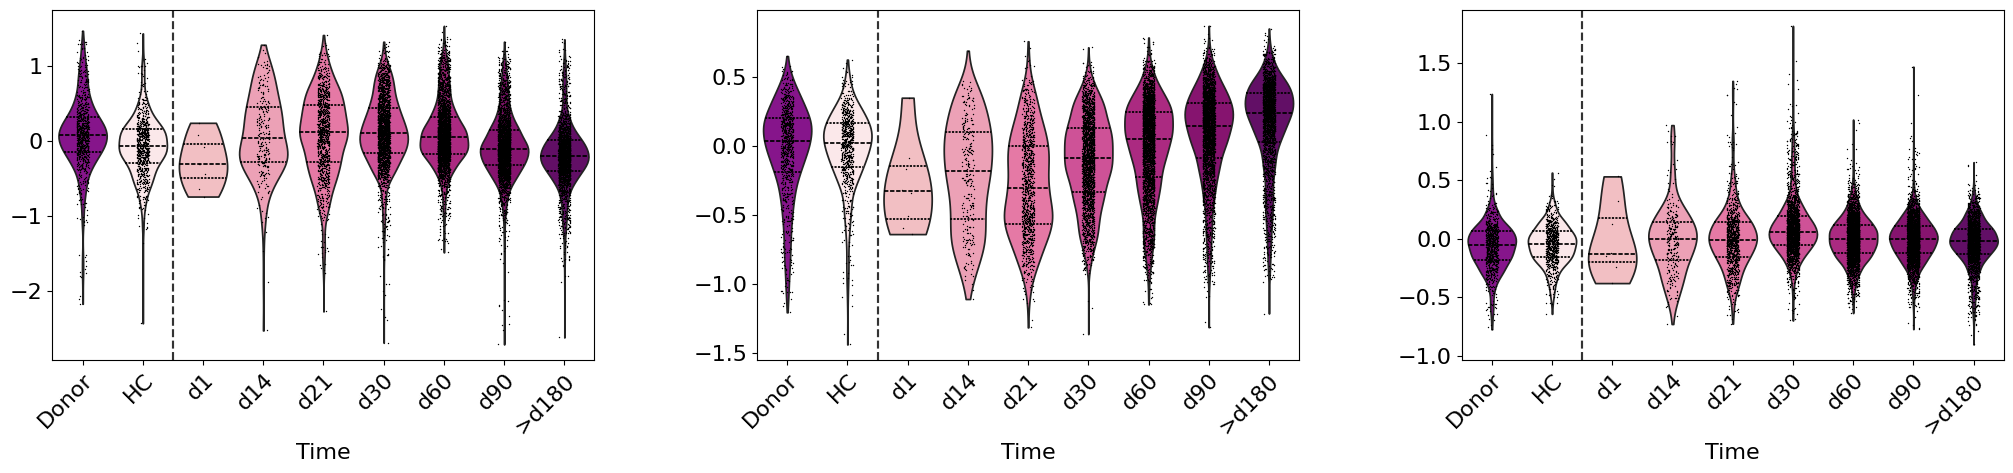

In [79]:
# 1. Call sc.pl.violin with show=False
axes_list = sc.pl.violin(
    NK_ad, 
    groupby='Time', 
    keys=['CD56_bright_score', 'CD56_dim_score', 'Proliferating_NK_score'], 
    inner='quart', 
    inner_kws={'color':'black'},
    show=False  # <-- This is the key change
)

# 2. Loop through each axis in the list
for ax in axes_list:
    # 3. Add a vertical dashed line
    ax.axvline(
        x=1.5,
        color='black',
        linestyle='--',
        linewidth=1.55,
        alpha=0.8
    )

    # 4. NEW: Adjust font sizes
    # Adjust title (what scanpy uses for the y-axis main label)
    ax.set_title(ax.get_title(), fontsize=18)

    # Adjust x-axis label
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)

    # Adjust y-axis label (scanpy leaves this blank, let's add one)
    ax.set_ylabel('', fontsize=16)
    
    # Adjust tick label sizes
    ax.tick_params(axis='x', labelsize=16, rotation=45) # For x-ticks
    ax.tick_params(axis='y', labelsize=16) # For y-ticks
    # This aligns the *right* side of the label to the tick
    plt.setp(
        ax.get_xticklabels(), 
        ha='right',          # Set horizontal alignment to 'right'
        rotation_mode='anchor' # Rotate around the alignment point
    )    

# 5. Now, save and show the final, modified plot
plt.savefig('figures/Time_Bright_Dim_pNK_Violins.png', dpi=600)
plt.show()

Statistical testing for the plots above (liner mixed effects)

In [78]:
# --- 1. Prepare Data ---
# Create a clean copy of the metadata
df = NK_ad.obs.copy()

# Select and Rename columns for cleaner formulas
# (Renaming avoids issues with spaces or special characters in formulas)
df_analysis = df[['Patient', 'Time', 'CD56_bright_score', 'CD56_dim_score', 'Proliferating_NK_score']].rename(columns={
    'Patient': 'PatientID',
    'Time': 'GroupTime',
    'CD56_bright_score': 'Bright_Score',
    'CD56_dim_score': 'Dim_Score',
    'Proliferating_NK_score': 'Prolif_Score'
})

# --- 2. THE FIX: Z-Score the Scores ---
# Scaling variables prevents the "Boundary of Parameter Space" error
scaler = StandardScaler()
score_cols = ['Bright_Score', 'Dim_Score', 'Prolif_Score']
df_analysis[score_cols] = scaler.fit_transform(df_analysis[score_cols])

# --- 3. Order Time (Chronological Logic) ---
def get_time_sort_key(time_str):
    if time_str == 'Donor': return -1
    if time_str == 'HC': return -2
    if '>' in time_str: return 999
    # Handle cases like 'd1'
    return int(time_str.strip('d'))

# Get unique values and sort them
all_group_times = df_analysis['GroupTime'].unique().tolist()
final_category_order = sorted(all_group_times, key=get_time_sort_key)

# Apply the category order (Sets 'Donor' as the reference/intercept)
df_analysis['GroupTime'] = pd.Categorical(
    df_analysis['GroupTime'],
    categories=final_category_order,
    ordered=False
)

print(f"Reference Group (Intercept): {final_category_order[0]}")

# --- 4. Define the Robust Fitting Function ---
def fit_lmm(formula, df):
    print(f"\n{'='*20}\nFitting: {formula}\n{'='*20}")
    
    # Define model with PatientID as the random grouping effect
    model = smf.mixedlm(formula, data=df, groups=df["PatientID"])
    
    # Fit using LBFGS optimizer and REML (Standard for publication)
    result = model.fit(reml=True, maxiter=5000)
    
    print(result.summary())
    return result

# --- 5. Run the Models ---

# Model A: CD56 Bright Score
res_bright = fit_lmm("Bright_Score ~ GroupTime", df_analysis)

# Model B: CD56 Dim Score
res_dim = fit_lmm("Dim_Score ~ GroupTime", df_analysis)

# Model C: Proliferating NK Score
res_prolif = fit_lmm("Prolif_Score ~ GroupTime", df_analysis)

Reference Group (Intercept): HC

Fitting: Bright_Score ~ GroupTime


/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


            Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  Bright_Score
No. Observations:  15306    Method:              REML        
No. Groups:        22       Scale:               0.8878      
Min. group size:   10       Log-Likelihood:      -20857.9148 
Max. group size:   4458     Converged:           Yes         
Mean group size:   695.7                                     
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          -0.243    0.213 -1.140 0.254 -0.661  0.175
GroupTime[T.Donor]  0.336    0.244  1.378 0.168 -0.142  0.814
GroupTime[T.d1]    -0.559    0.411 -1.359 0.174 -1.365  0.247
GroupTime[T.d14]    0.391    0.245  1.595 0.111 -0.090  0.872
GroupTime[T.d21]    0.649    0.240  2.703 0.007  0.178  1.120
GroupTime[T.d30]    0.498    0.239  2.083 0.037  0.029  0.967
GroupTime[T.d60]    

/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


            Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  Prolif_Score
No. Observations:  15306    Method:              REML        
No. Groups:        22       Scale:               0.9081      
Min. group size:   10       Log-Likelihood:      -21032.8572 
Max. group size:   4458     Converged:           No          
Mean group size:   695.7                                     
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          -0.509    0.238 -2.136 0.033 -0.976 -0.042
GroupTime[T.Donor]  0.123    0.273  0.450 0.653 -0.412  0.657
GroupTime[T.d1]     0.264    0.432  0.612 0.541 -0.582  1.110
GroupTime[T.d14]    0.567    0.274  2.072 0.038  0.031  1.103
GroupTime[T.d21]    0.748    0.269  2.782 0.005  0.221  1.275
GroupTime[T.d30]    0.883    0.268  3.298 0.001  0.358  1.408
GroupTime[T.d60]    

/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 2.544360
  warnings.warn(msg, ConvergenceWarning)
